# Examining Rated Power and Average Duration of Load in House
## List of Houses in Dataset

In [1]:
from os import path
from os import getcwd, listdir
path_to_data = path.join('..', 'data', 'houses')
houses = listdir(path_to_data)
for h in houses: print(path.splitext(h)[0])

64613
69914
70177
70210
70243
70277
91341
91910
91911
91912
97245


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
house_id = 69914

### Importing Data and cleaning up

In [3]:
df = pd.read_csv(path.join(path_to_data,str(house_id)+'.csv'))
df.drop(columns=['Unnamed: 0'], inplace=True)
df.drop_duplicates(keep='first', inplace=True)
df['reading_datetime'] = pd.to_datetime(df['reading_datetime'])
df.set_index('reading_datetime', inplace=True)
df.sort_index(inplace=True)
df['circuit_id_monitor'] = df.circuit_id.astype(str) + ' <<' +df.monitors+'>>'

original_set = df.reset_index()
original_set = original_set.pivot(index='reading_datetime', columns='circuit_id_monitor', values=['energy', 'energy_pos', 'energy_neg'])
net_energy = original_set[:]['energy']

# print('Setup Complete')


for m in df.monitors.unique():
    print(m)

ac_load_net
load_other
load_refrigerator
load_stove
pv_site_net
load_air_conditioner


#### Select monitor to analyse

In [4]:
load_type = 'air_conditioner'
print(load_type)

air_conditioner


### Rated Power Calculation
The reading comes as Wh consumed in a 5 minute period <br>
It needs to be converted to Power in kW to understand the draw of appliance

$ R = E \times \frac{5}{60} \times 1000 $

The appliance is not guaranteed to start neatly at the start of each 5 minute interval.
It cannot be assumed the average rated power is the true rated power as there are significant
lower outliers to the power calculated.

Constraining the power values considered to periods where the appliance is "on" for 90% of the time
gives a better result for rated power.

"on" period is defined as:

$ on = \frac{power}{max(power)} $

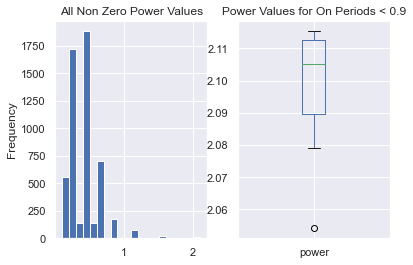

Rated Power: 2.11kW


In [5]:
load_investigation = net_energy.filter(regex=load_type).copy(deep=True)
load_investigation.rename(columns={load_investigation.columns[0]:'power'}, inplace=True)
load_investigation = (load_investigation * 12) / 1000
rated_power = load_investigation.power.max()
load_investigation['on_time'] = (load_investigation.power / rated_power)

on = load_investigation.loc[load_investigation.power > 0.1]
fig, ax = plt.subplots(nrows=1, ncols=2)
on.power.plot.hist(title='All Non Zero Power Values', ax=ax[0], bins=20)
period = 0.9
on = load_investigation.loc[load_investigation.on_time > period]
on.power.plot.box(title='Power Values for On Periods < ' + str(period), ax=ax[1])
plt.show()
rated_power = on.power.median()
load_investigation['on_time'] = (load_investigation.power / rated_power) * 5
print('Rated Power: ' + "{:.2f}".format(rated_power) + 'kW')


### Duration Calculation

For each Day the total period the load was on was extracted.

Presented below is the average duration the load was on for and also the day it was on for the longest period.

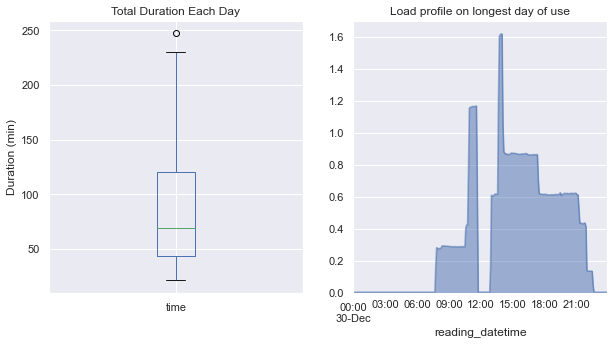

Duration Average: 1.44h


In [6]:
load_24h = load_investigation[['power', 'on_time']].copy(deep=True)
load_24h['time'] = load_24h.on_time
load_24h = load_24h.resample('24h', offset=12).sum()
non_zero_days = load_24h[load_24h.time > 20].time
longest_day = load_24h.time.idxmax()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
load_investigation[str(longest_day.date())].power.clip(lower=0).plot.area(title='Load profile on longest day of use',ax=ax[1], alpha=0.5)
non_zero_days.plot.box(title='Total Duration Each Day', ax=ax[0])
ax[0].set_ylabel('Duration (min)')
plt.show()

average_duration = non_zero_days.mean()

print('Duration Average: ' + "{:.2f}".format((average_duration / 60)) + 'h')
